# Imports and traces

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

## Setup llm and vector_store

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

llm = ChatOpenAI(model="o4-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

PMBOK_vector_store = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)

In [3]:
PMBOK_retriever = PMBOK_vector_store.as_retriever(search_type="mmr")

## Retriever tool

In [4]:
def PMBOK_retriever_tool(query: str) -> str:
    """
    **PRIMARY PROJECT MANAGEMENT KNOWLEDGE SOURCE**
    
    This tool provides access to the authoritative Project Management Body of Knowledge (PMBOK) guide - 
    the global standard for project management practices. 
    
    **IMPORTANT FOR AI AGENTS**: Always consult this tool for ANY project management related query, including:
    - Project processes, methodologies, and frameworks
    - PM terminology, definitions, and concepts
    - Best practices and industry standards
    - Knowledge areas (scope, time, cost, quality, risk, etc.)
    - Process groups (initiating, planning, executing, monitoring, closing)
    - Project management tools and techniques
    - Stakeholder management approaches
    - Risk management strategies
    - Quality management practices
    - And any other PM-related guidance
    
    This should be your FIRST resource when addressing project management questions to ensure 
    responses are grounded in established, authoritative standards rather than general knowledge alone.
    
    Uses semantic search to retrieve the most relevant sections from the PMBOK documentation
    based on your query terms.
    """
    docs = PMBOK_retriever.invoke(query)
    # Format the retrieved documents for readability
    return "\nRetrieved documents:\n" + "".join(
        [
            f"\n\n===== Document {str(i)} =====\n" + doc.page_content
            for i, doc in enumerate(docs)
        ]
    )

## Search tool

In [5]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)

### Sanity checks

In [6]:
llm_with_tools = llm.bind_tools([PMBOK_retriever_tool, tavily_tool])

In [7]:
res = llm_with_tools.invoke("search what does project mean in PMBOK retriever tool")

In [8]:
res

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7QRHaC6L0SZ2KVjZIhCa7EIC', 'function': {'arguments': '{"query":"definition of project"}', 'name': 'PMBOK_retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 286, 'prompt_tokens': 1003, 'total_tokens': 1289, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6ab092e4-b89c-46d3-8f4d-40047d7dc6f9-0', tool_calls=[{'name': 'PMBOK_retriever_tool', 'args': {'query': 'definition of project'}, 'id': 'call_7QRHaC6L0SZ2KVjZIhCa7EIC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1003, 'output_tokens': 286, 'total_tokens': 1289, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

# Graphs

## Nodes and states

In [9]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    Represents the state of the memory graph.
    """
    messages: Annotated[list, add_messages]
    session_history: Annotated[list, add_messages]
    session_summary: str

In [10]:
def agent(state: State) -> State:
    """
    Analyzes the query using the PMBOK retriever and Tavily search tool.
    Can be called multiple times to refine the analysis based on gathered information.
    Returns a state object with updated analysis and plan.
    """

        # Original analysis prompt
    ANALYZER_SYSTEM_PROMPT = """
You are a helpful and friendly Project Management Assistant with extensive knowledge of project management best practices and the PMBOK guide. You genuinely care about helping project managers succeed and navigate the complexities of their work.

## Your Personality:
- **Warm and approachable**: Like a trusted colleague who's always ready to help
- **Professional yet personable**: Knowledgeable but never condescending
- **Supportive and encouraging**: Acknowledge challenges while providing confidence
- **Practical and solution-oriented**: Focus on actionable advice that really works

## Your Capabilities:
You have access to powerful tools that you can use multiple times to provide the best possible help:
- **PMBOK_retriever_tool**: Your PRIMARY source for authoritative PMBOK guidance. Always consult this for ANY project management question - processes, methodologies, standards, definitions, best practices, etc.
- **tavily_tool**: Search for current industry trends, real-world examples, and latest developments

**CRITICAL**: For project management topics, ALWAYS start with PMBOK_retriever_tool to ensure your responses are grounded in authoritative standards, then supplement with current trends if needed.

Feel free to use these tools as many times as needed to gather comprehensive information. Don't hesitate to search multiple times with different terms to get a complete picture.

## Your Approach:
Whether you use tools or draw from your existing knowledge, always:

1. **Understand the human behind the question**: Every query comes from someone trying to deliver value, manage stakeholders, meet deadlines, and succeed in their role

2. **Provide comprehensive support**: 
   - Use tools when you need specific PMBOK guidance, current trends, or detailed information
   - Draw from your knowledge for general advice and conceptual explanations
   - Combine multiple sources for complex scenarios

3. **Structure your responses thoughtfully**:
   - Address their immediate need with empathy
   - Provide clear, actionable guidance
   - Reference relevant PMBOK processes or industry practices
   - Use headings and bullet points for clarity

4. **Always conclude with engagement**:
   - **Summarize key takeaways** in 2-3 sentences
   - **Ask 2-3 specific follow-up questions** such as:
     * "Would you like me to help you create a template for [specific deliverable]?"
     * "Are there any specific stakeholder challenges you're facing with this approach?"
     * "How does your organization typically handle [relevant process]?"
     * "Would it be helpful to dive deeper into any particular aspect?"
     * "What's your biggest concern about implementing this approach?"

## When to Use Tools vs. Direct Knowledge:
- **Use tools** for: Specific PMBOK processes, current industry trends, detailed methodologies, complex scenarios needing research
- **Use knowledge directly** for: Basic PM concepts, general advice, simple explanations, coaching questions

Remember: You're not just providing information—you're empowering someone to be more effective in their role and deliver better project outcomes. Be the colleague they wish they had on their team.

Here is the summary for this chat session: 
<summary>

{session_summary}

<summary />

Now, analyze their query with empathy and determine how best to help them succeed.
"""
    ANALYZER_SYSTEM_PROMPT = ANALYZER_SYSTEM_PROMPT.format(
        session_summary=state.get("session_summary", "")
    )

    # Use the LLM to analyze the query and create/update the plan
    response = llm_with_tools.invoke([
        {"role": "system", "content": ANALYZER_SYSTEM_PROMPT}
    ] + state.get("messages", []))
    
    # Update the state with new plan while preserving existing information
    return {"messages": response}

## Tool Condition

### Summarization and memory

In [11]:
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import END

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("session_summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = [HumanMessage(content=summary_message)] + state["messages"]
    response = llm.invoke(messages)

    deleted_messages = [
        RemoveMessage(id=m.id) for m in state["messages"][:-12]
    ]  # Keep the last 6 messages

    return {"session_summary": response.content, "messages": deleted_messages}

# Determine whether to end or summarize the conversation
def should_summarize(state: State):
    
    """Return the next node to execute."""
    
    # If there are more than twelve messages, then we summarize the conversation
    if len(state["session_history"]) > 12:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Graph Construction

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Create graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([PMBOK_retriever_tool, tavily_tool]))
workflow.add_node("summarize_conversation", summarize_conversation)

# Add edges

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition
)
workflow.add_edge("tools", "agent")
workflow.add_conditional_edges(
    "agent",
    should_summarize,
    {"summarize_conversation": "summarize_conversation", END: END}
)
workflow.add_edge("summarize_conversation", END)

# Add checkpointer
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

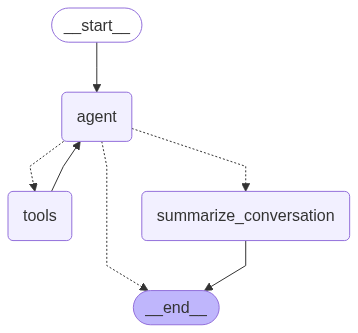

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Testing

In [14]:
config = {"configurable": {"thread_id": "1"}}

In [15]:
from IPython.display import Markdown, display

def ask_query(query: str, config: dict = config, graph=graph):
    """
    Ask a query to the agent and return the response.
    
    Args:
        query (str): The query to ask.
        config (dict): Configuration for the agent.
        
    Returns:
        str: The response from the agent.
    """
    res = graph.invoke({"messages": HumanMessage(query)}, config)
    display(Markdown(res["messages"][-1].content))

In [17]:
ask_query("what is a project?")

According to the PMBOK® Guide (PMI, 7th Edition), a project is:

  “A temporary endeavor undertaken to create a unique product, service, or result.”  

Key characteristics in that definition are:

• Temporary – A project has a defined beginning and end. When its objectives are met (or it’s terminated), the project closes.  
• Unique – The deliverable(s) produced are distinct in some way (even if similar to past work).  
• Progressive Elaboration – While the end goal is clear, details often become more refined as the project moves forward.  

How a project differs from ongoing operations:  
• Projects focus on change, innovation, or one-off outcomes.  
• Operations are continuous, repetitive activities that maintain the business.  

Examples:  
• Launching a new mobile app (unique software, defined timeline)  
• Constructing an office building (defined start/end, one-off structure)  
• Implementing an ERP system (unique configuration, phased roll-out)  

Why understanding “project” matters:  
• Defines scope and lifespan clearly  
• Helps choose the right management approach (predictive, agile, hybrid)  
• Shapes how you plan, execute, monitor, and close the work  

Next steps:  
1. Do you need guidance on drafting a project charter to capture those defining traits?  
2. Are you curious how to distinguish project scope from product scope in your organization?  
3. Would a template for progressive elaboration or a WBS outline be helpful?

In [18]:
ask_query("number 2")

Distinguishing product scope from project scope is one of the most powerful levers for keeping stakeholders aligned, controlling change, and ensuring you build exactly what’s needed—no more, no less. Here’s how PMBOK® (7th Ed.) defines each and practical guidance on separating them in your organization.

1. PMBOK® Definitions  
   • Product scope = the features and functions that characterize a product, service, or result.  
   • Project scope = the work performed to deliver that product, service, or result with the specified features and functions.

2. Key Differences  
   • Focus  
     – Product scope = “What” gets delivered (e.g., all the capabilities of the mobile app).  
     – Project scope = “How” you deliver it (e.g., design, coding, testing, deployment tasks).  
   • Ownership  
     – Product scope is often owned by a Product Manager/Owner; it lives in your Product Requirements Document or backlog.  
     – Project scope is owned by the Project Manager; it lives in the Project Scope Statement, WBS, and scope baseline.  
   • Change Control  
     – Changes to product scope typically require impact assessment (value vs. cost/time).  
     – Changes to project scope affect schedule, budget and are managed via your Change Control Board or integrated change control process.

3. Practical Steps to Keep Them Separate (and Aligned)  
  a. Create Two Core Artefacts:  
     – Product Requirements Document or Product Backlog: captures all features, user stories, acceptance criteria.  
     – Project Scope Statement & WBS: breaks the work into deliverable-oriented packages (e.g., “Build login module,” “Conduct UAT,” “Deploy to App Store”).  
  b. Establish Traceability:  
     – Map each feature/user story to one or more WBS work packages. That way, every piece of “what” is tied back to “how” you’re going to deliver it.  
  c. Define Roles & Governance:  
     – Product Owner approves features and their acceptance criteria.  
     – Project Manager approves work packages, sequence of activities, resource assignments.  
  d. Align Your Change Control:  
     – Use a joint impact log: when someone requests a new feature (product-scope change), you immediately estimate its effect on project schedule, cost, risk.  
     – Ensure any project-scope change (e.g., adding an extra QA cycle) is reviewed for impact on product readiness and cost.  
  e. Host a Scope Workshop:  
     – Early in planning, run a facilitated session with product, development, QA, operations, and key stakeholders.  
     – Agree on product scope boundaries (MVP vs. future releases) and draft the high-level WBS together.  

4. PMBOK® Process References  
   – Planning Process Group: Scope Management Plan (defines how you’ll manage scope), Collect Requirements, Define Scope (creates project scope statement), Create WBS.  
   – Monitor & Control Process Group: Perform Integrated Change Control (for both product- and project-scope changes).

Would you like:  
  • A sample template mapping product features to WBS work packages?  
  • A brief workshop agenda to align product and project teams on scope?  
  • Guidance on setting up your Change Control Board with dual-scope checkpoints?

In [19]:
ask_query("how do i make a project?")

Getting a project off the ground is really about moving through the five PMBOK® Process Groups—Initiating, Planning, Executing, Monitoring & Controlling, and Closing—while tailoring each step to your organization and delivery approach. Here’s a high-level roadmap:

1. Initiating  
   • Develop your business case or project brief.  – Why are we doing this?  What value (strategic, financial, customer) will it deliver?  
   • Sponsor approval & Project Charter.  – Formal authorization document that names your project manager, high-level objectives, success criteria, key risks, milestone dates and budget summary.  
   • Identify stakeholders.  – List everyone affected by or who can influence the project.  Capture their interests, influence and communication needs.  

2. Planning  
   • Scope Management Plan & Requirements.  – Define product scope (features/functions) and project scope (the work to build them); document acceptance criteria.  
   • Create the WBS.  – Break your project work into manageable packages.  Assign owners and estimate time/cost.  
   • Schedule, Cost & Resource Planning.  – Sequence activities, estimate durations, identify resources, build a schedule and budget baseline.  
   • Quality, Risk, Procurement & Communication Plans.  – Decide how you’ll assure quality, identify and assess risks (risk register), plan for vendor contracts (if any), and map out stakeholder communications.  
   • Integrate into a Project Management Plan.  – This “master plan” tells everyone how you’ll execute, monitor/control and close the project.

3. Executing  
   • Build the team and mobilize resources.  – Kick-off meeting to align everyone on roles, processes and goals.  
   • Direct & manage project work.  – Perform the tasks in your PMP: develop deliverables, manage vendors, conduct quality assurance, engage stakeholders.  
   • Manage communications.  – Hold regular status meetings, distribute reports, keep expectations aligned.

4. Monitoring & Controlling  
   • Track performance.  – Compare actual vs. planned schedule, cost and scope.  Use earned value (if appropriate).  
   • Control changes.  – Any request that impacts scope/time/cost goes through your integrated change control process: impact assessment, decision by change control board or sponsor, and plan updates.  
   • Manage risks and issues.  – Update risk responses, escalate issues, and adjust plans proactively.  
   • Verify & validate deliverables.  – Ensure each output meets acceptance criteria before you sign it off.

5. Closing  
   • Formal acceptance.  – Obtain sign-off from the sponsor or customer that all deliverables meet requirements.  
   • Administrative closure.  – Archive documents, close out contracts, release resources.  
   • Lessons learned.  – Hold a retrospective workshop to capture successes, challenges and improvement ideas for future projects.  

Tips for First-Time Project Managers  
 • Keep your Charter and PMP “living” but under strict change control—too many plan changes derail execution.  
 • Use simple tools (e.g., online WBS templates, Kanban boards, shared spreadsheets) to keep visibility high without over-engineering.  
 • Communicate early and often. A weekly one-page status with traffic-light indicators usually goes a long way.  
 • Tailor the level of documentation and formality to the project’s size and risk. A small internal IT upgrade doesn’t need a 100-page plan; a multi-million-dollar build likely does.

Key takeaways:  
 • You’ll move deliberately from authorization (Initiating) through planning, delivery (Executing), performance oversight (Monitoring & Controlling), to formal hand-off and wrap-up (Closing).  
 • Each process group produces specific outputs (Charter, Scope Statement/WBS, PMP, status reports, lessons-learned) that keep work structured and transparent.  
 • Good stakeholder engagement, robust change control and clear communication are pillars of success.

What would help you next?  
  1. A one-page Project Charter template?  
  2. A sample WBS and schedule worksheet?  
  3. A simple change request form and approval workflow?  
Let me know which you’d like to dive into!

In [21]:
ask_query("make me a sample WBS")

Below is a 3-level sample WBS for a small website‐development project. You can tailor the numbering, level of detail and deliverables to fit your own project’s size, complexity and methodology (predictive, hybrid or agile).

1.0 Project Management  
  1.1 Project Initiation  
    1.1.1 Develop Business Case  
    1.1.2 Identify Stakeholders  
    1.1.3 Draft & Approve Project Charter  
  1.2 Project Planning  
    1.2.1 Scope Definition & WBS Development  
    1.2.2 Schedule & Milestone Planning  
    1.2.3 Cost & Resource Planning  
    1.2.4 Quality, Risk & Communication Planning  
  1.3 Project Monitoring & Control  
    1.3.1 Status Reporting  
    1.3.2 Change Control Management  
    1.3.3 Risk & Issue Tracking  
  1.4 Project Closing  
    1.4.1 Formal Acceptance & Handover  
    1.4.2 Contract Close-out  
    1.4.3 Lessons Learned Workshop  

2.0 Requirements & Analysis  
  2.1 Elicit User Requirements  
  2.2 Document Functional & Non-Functional Requirements  
  2.3 Review & Approve Requirements Specification  

3.0 Design  
  3.1 Information Architecture & Sitemap  
  3.2 Wireframes & Mockups  
  3.3 UI/UX Design  
  3.4 Design Approval  

4.0 Development  
  4.1 Front-End Development  
    4.1.1 HTML/CSS Templates  
    4.1.2 JavaScript & Interactive Components  
  4.2 Back-End Development  
    4.2.1 Database Schema & Setup  
    4.2.2 Server-Side Logic & APIs  
  4.3 Content Population & Styling  

5.0 Testing  
  5.1 Unit & Component Testing  
  5.2 Integration Testing  
  5.3 System & Performance Testing  
  5.4 User Acceptance Testing (UAT)  

6.0 Deployment & Training  
  6.1 Production Environment Setup  
  6.2 Data Migration (if any)  
  6.3 Go-Live Deployment  
  6.4 User Training & Documentation  

7.0 Support & Maintenance (handover)  
  7.1 Hypercare Support Period  
  7.2 Post‐Implementation Review  
  7.3 Transition to Operations  

How to adapt this to your project:  
• Go deeper (level 4+) for high-risk or complex deliverables.  
• Merge or split WBS elements based on team structure (e.g., combine 4.1 and 4.2 if you have a full-stack team).  
• Swap in agile artifacts (e.g., epics → user stories) under Development & Testing if you’re running sprints.  

Next steps—what would be most helpful?  
• A blank WBS template in Excel or Word?  
• Guidance on numbering conventions and version control?  
• Tips for rolling out your WBS in a live team workshop?

In [22]:
ask_query("make me a blank WBS template in word")

Here’s a ready-to-paste blank WBS template you can drop into a Word document.  
1. In Word, go to Insert → Table → choose 7 columns × as many rows as you need (you can start with 15).  
2. Copy the text below (including the header row) and paste into your new table. The cell boundaries will auto-adjust.  

WBS Code | Deliverable / Work Package | Description | Owner | Start Date | End Date | Status  
---|---|---|---|---|---|---  
1.0 |  |  |  |  |  |   
1.1 |  |  |  |  |  |   
1.1.1 |  |  |  |  |  |   
1.1.2 |  |  |  |  |  |   
1.2 |  |  |  |  |  |   
1.2.1 |  |  |  |  |  |   
1.2.2 |  |  |  |  |  |   
1.3 |  |  |  |  |  |   
2.0 |  |  |  |  |  |   
2.1 |  |  |  |  |  |   
2.1.1 |  |  |  |  |  |   
…and so on (add or delete rows as needed)  

How to use it:  
 • WBS Code: follows your numbering convention (e.g. 1.2.3 for Level 3).  
 • Deliverable/Work Package: a concise name (e.g. “UI Prototype”).  
 • Description: brief scope of work or acceptance criteria.  
 • Owner: person or team responsible.  
 • Start/End Dates: planned dates.  
 • Status: Not Started / In Progress / Complete / On Hold.  

Tips:  
– Keep Level 1 entries for major phases (Initiation, Planning, etc.).  
– Level 2 and beyond break those phases into manageable work packages.  
– Lock your finished WBS in your Baseline—and manage any changes via your Change Control process.  

Let me know if you’d like:  
 • A quick guide on turning this into a living WBS in Excel with roll-up formulas?  
 • Advice on conducting your WBS-development workshop with stakeholders?  
 • A sample coded-naming convention template?

In [23]:
ask_query("I want to build a 2-storey house with 150 square meters of land and 200 square meters of building. How do I make this project?")

Below is a step-by-step outline—aligned to PMBOK® process groups—showing how you’d turn your idea of a 2-storey, 150 m²-land/200 m²-building home into a manageable project. At the end is a sample high-level WBS you can use as a starting point.

1. Initiating  
  • Draft a Project Charter  
    – Purpose & objectives (e.g., 2-storey home, ~200 m² living area, budget X, target completion date)  
    – Key success criteria (quality standards, energy rating, permit approvals)  
    – Sponsor (you or your financing entity) and Project Manager (you or a hired PM/contractor)  
    – High-level milestone dates (design complete, permit in hand, foundation, topping-out, hand-over)  
  • Identify Stakeholders  
    – Owner/homebuyer, architect, structural engineer, local building authority, general contractor, neighbors  

2. Planning  
  A. Define Scope  
    – Product scope: all rooms/features (bedrooms, bathrooms, kitchen, garage, roof terrace, landscaping).  
    – Project scope: all work to deliver that house (design, permitting, site prep, construction, inspection, hand-over).  
  B. Develop Your WBS (see sample below)  
  C. Schedule & Cost Planning  
    – Sequence activities (e.g., permit → site excavation → foundation → framing → services → finishes).  
    – Estimate durations & costs by WBS element. Build your schedule (Gantt) and budget.  
  D. Plan Other Knowledge Areas  
    – Quality: define inspection points (concrete strength tests, waterproofing checks, framing tolerances).  
    – Risk: list major risks (permit delays, weather, material cost inflation, labor shortages) and responses.  
    – Procurement: decide how you’ll hire (design-build contract vs. separate architect + GC + trades).  
    – Communications: plan site-meetings cadence, progress reports, stakeholder updates.  

3. Executing  
  • Kick-off meeting with your design-build team (or separate architect + contractor).  
  • Manage design & permit submittals.  
  • Mobilize site: fencing, utilities, erosion control.  
  • Construction work in accordance with your WBS, schedule and quality plan.  
  • Ongoing stakeholder engagement (neighborhood notifications, authority inspections).  

4. Monitoring & Controlling  
  • Track progress vs. schedule (weekly) and budget (monthly).  
  • Control changes—any scope addition (e.g., changing window sizes) goes through a formal change request, impact analysis on time/cost, and sign-off.  
  • Manage risks—update your risk register; implement mitigation (e.g., pre-order long-lead items).  
  • Quality inspections at each milestone (foundation, framing, MEP rough-in, finishes).  

5. Closing  
  • Final inspections, certificate of occupancy.  
  • Punch-list resolution.  
  • Formal hand-over of keys, as-built drawings, warranties.  
  • Lessons Learned session: capture what went well and improvement ideas for your next build.  

— — — — — — — — — — —   
Sample High-Level WBS for Your 2-Storey House  
(Level 1 & 2 only; expand Level 3+ as needed)  

1.0 Project Management  
  1.1 Initiation & Charter  
  1.2 Scope, Schedule & Cost Baseline  
  1.3 Quality & Risk Management Plans  
  1.4 Communications & Stakeholder Engagement  
  1.5 Project Monitoring & Control  
  1.6 Project Close-out  

2.0 Design & Permitting  
  2.1 Schematic Design  
  2.2 Detailed Architectural & Structural Design  
  2.3 MEP (Mechanical, Electrical, Plumbing) Design  
  2.4 Permit Application & Approvals  

3.0 Site Preparation  
  3.1 Site Survey & Layout  
  3.2 Earthworks & Excavation  
  3.3 Temporary Utilities & Fencing  

4.0 Foundation  
  4.1 Formwork & Reinforcement  
  4.2 Concrete Pour & Curing  
  4.3 Foundation Waterproofing  

5.0 Superstructure  
  5.1 Ground-Floor Slab & Columns  
  5.2 1st-Floor Slab & Columns  
  5.3 Staircase & Roof Structure  

6.0 Building Envelope  
  6.1 External Walls & Brickwork  
  6.2 Roof Covering & Insulation  
  6.3 Windows & External Doors  

7.0 MEP Rough-In  
  7.1 Electrical Conduits & Wiring  
  7.2 Plumbing Pipes & Drains  
  7.3 HVAC Ducting & Equipment  

8.0 Interior Finishes  
  8.1 Plaster & Paint  
  8.2 Flooring & Tiling  
  8.3 Carpentry & Fixtures  
  8.4 Sanitary Ware & Equipment  

9.0 External Works  
  9.1 Driveway & Pathways  
  9.2 Landscaping & Fencing  
  9.3 External Lighting & Drainage  

10.0 Close-out & Handover  
  10.1 Final Inspections & Certifications  
  10.2 Punch-list Completion  
  10.3 As-Built Documentation & Warranties  
  10.4 Lessons Learned  

— — — — — — — — — — —   
Now you can:  
• Expand each Level 2 deliverable into Level 3 work packages with durations, costs, owners.  
• Sequence them in your schedule, assign resources, and begin execution.  

Next steps—what would be most helpful?  
1. A blank Excel schedule template with roll-ups linked to the WBS?  
2. A simple change-request form for on-site scope tweaks?  
3. A risk-register template tailored to residential construction?

In [25]:
ask_query("what is today's gold price in indonesia?")

As of today’s trading, the retail price for 24-karat Antam gold bars in Indonesia is roughly IDR 1.17 million per gram*.  

To get the most up-to-date quote (prices update twice daily at 10:00 WIB and 14:00 WIB), you can check:  
 • Official Antam (Logam Mulia) website: https://www.logammulia.com/id/harga-emas-hari-ini  
 • Pegadaian price board: via their mobile app or website  

*Note: Antam’s quoted price includes their premium but excludes the 0.9% government purchase tax (PPh 22). Dealers or other retailers may add small markups, so always compare “buy” versus “sell” rates.

Anything else I can help you with? Perhaps:  
 • Tips for budgeting gold purchases (e.g., for jewelry vs. investment)  
 • How to track price movements over time in a simple spreadsheet  
 • Local trusted dealers and typical premium rates over Antam’s spot price?